In [1]:
%matplotlib inline

Modified from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

### Why PyTorch?

- open source
    - part of the Linux Foundation
- pythonic
- more and more frequently used in the community

New Repositories on [Papers With Code](https://paperswithcode.com/) - a platform for machine learning benchmarks and papers.

<img src="./imgs/pytorch.png" width="600">


# Training a Classifier

Hands-on-example with the CIFAR10 dataset. Facts about this dataset:

- It has 10 classes: 'airplane’, 'automobile’, 'bird’, 'cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’
- Images are of the size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](imgs/cifar10.png)


### 1. Load and preprocess CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

**Important preprocessing steps:**

- Normalize data
    - bring it into a normal distribution
    - makes the training more stable and it has desirable properties for the gradient flow
- Data augmentation
    - examples: flip images, change color channels, use random crops,...
    - artificially enlarge the dataset by adding slightly modified copies of already existing images
    - usefulness in combating overfitting and making models generalize better

In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

batch_size = 128

Using ``torchvision``, it’s extremely easy to load CIFAR10.

- Usually, you have to construct a custom dataset for your data. [Here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) is a nice description how it can be done with PyTorch.


In [4]:
import numpy as np

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


**Data split:**

- different variants
    - train / test split
    - train / validation / test split

<img src="./imgs/split.png" width="600">

We manually create a validation set from train set since the CIFAR10 dataset only offers a train/test split.

<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [5]:
from sklearn.model_selection import train_test_split

train_targets = trainset.targets

train_idx, val_idx = train_test_split(
    np.arange(len(train_targets)),
    test_size=0.2,
    shuffle=True,
    stratify=train_targets,
    random_state=0
)

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, train_idx), batch_size=batch_size, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, val_idx), batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


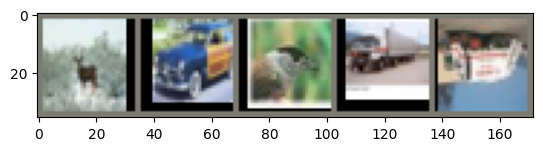

deer  car   bird  truck truck


In [6]:
import matplotlib.pyplot as plt
import numpy as np


unnormalize = transforms.Compose([
    transforms.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
    transforms.Normalize((-0.4914, -0.4822, -0.4465), (1., 1., 1.)),
])

# functions to show an image
def imshow(img):
    img = unnormalize(img)     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
n_imgs = 5
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images[:n_imgs], labels[:n_imgs]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(n_imgs)))

### 2. Define a Neural Network

![cnn](imgs/mnist.png)

**Example Convolutional Neural Network:**

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Architectures**

Creating architectures from scratch is difficult

- there are a lot of different techniques and approaches (batchnorm, layernorm, activation functions)
- the search for a good architecture takes a lot of time and resources (training many different models)

In practice pretrained models are used:

- trained on huge amount of data
- great performance on benchmark datasets
- good starting point for fine-tuning on custom dataset
- faster training


**Pytorch Image Models**

[Timm](https://github.com/rwightman/pytorch-image-models) is a great library for (pretrained) image classification models.

In [8]:
import timm

timm.list_models('vit_base_*')

['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_clip_laion2b',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224']

<img src="./imgs/vit.png" width="800">

In [9]:
model_name = 'vit_base_patch8_224_in21k'
vit = timm.create_model(model_name, pretrained=True, img_size=32, num_classes=10, drop_rate=0.1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vit = vit.to(device)

In [10]:
convnext = timm.create_model('convnext_base_in22k', pretrained=True, num_classes=10)
convnext = convnext.to(device)

### 3. Define a loss function, optimizer, scheduler and metric

We use the CrossEntropy loss to maximize the activation of the correct class during training.

- Network output: a floating point for each class, where higher numbers indicate that it is more likely to be a class (usually a softmax is applied on this tensor to get a probability distribution)
- Label: index of the correct label

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('Network output:\n', vit(images[:1].to(device)), '\n')
print('Network output (+ softmax):\n', F.softmax(vit(images[:1].to(device)), dim=1), '\n')
print('Label:\n', labels[:1], '\n')


Network output:
 tensor([[ 1.1741, -4.2544,  1.1448,  1.0618,  1.3522, -1.5692, -2.3421, -0.1794,
          0.3702,  0.2976]], device='cuda:0', grad_fn=<AddmmBackward0>) 

Network output (+ softmax):
 tensor([[0.0385, 0.0047, 0.3477, 0.0536, 0.3095, 0.0069, 0.0440, 0.0058, 0.0142,
         0.1751]], device='cuda:0', grad_fn=<SoftmaxBackward0>) 

Label:
 tensor([3]) 



In [12]:
from dataclasses import dataclass


@dataclass
class TrainInputs:
    net: nn.Module
    train_loader: torch.utils.data.DataLoader
    val_loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    scheduler: torch.optim.lr_scheduler._LRScheduler
    name: str
    epochs: int

Next, we define the **optimizer** and the **learning rate schedule**.

<img src="./imgs/gradient_descent.png" width="600">

In [13]:
import torch.optim as optim

optimizer = optim.SGD(vit.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

Finally, we define the accuracy as our metric.

In [14]:
def acc(net, testloader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total * 100

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [15]:
from copy import deepcopy


def train(train_inputs: TrainInputs):

    # check if cuda gpu is available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    train_inputs.net.to(device)
    print(f'used device: {device}')

    for epoch in range(train_inputs.epochs):  # loop over the dataset multiple times

        train_losses = []
        best_model = None
        best_score = np.Inf

        criterion = nn.CrossEntropyLoss()
        train_inputs.net.train()
        # get the inputs; data is a list of [inputs, labels]
        for inputs, labels in train_inputs.train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            train_inputs.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = train_inputs.net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # get statistics
            train_losses.append(loss.item())

        # put network in evaluation mode and compute validation accuracy
        train_inputs.net.eval()
        with torch.no_grad():
            val_acc = acc(train_inputs.net, train_inputs.val_loader)

        # store best model based on the validation set
        if val_acc < best_score:
            best_model = deepcopy(train_inputs.net)
            PATH = f'./cifar_{train_inputs.name}.pth'
            torch.save(best_model.state_dict(), PATH)
        
        # log statistics
        with open(f'{train_inputs.name}_logs.csv', 'a') as file:
            file.write(f'{np.mean(train_losses):.3f}, {val_acc:.3f}\n')
        print(f'[{epoch + 1}] train loss: {np.mean(train_losses):.3f} val acc: {val_acc:.3f}')

        # move on in the learning rate schedule
        train_inputs.scheduler.step()

    print('Finished Training')
    return best_model, train_inputs.net

In [16]:
train_inputs = TrainInputs(vit, train_loader, val_loader, optimizer, scheduler, model_name, 2)

best_model, vit = train(train_inputs)

used device: cuda:0
[1] train loss: 1.652 val acc: 55.140
[2] train loss: 1.213 val acc: 63.930
Finished Training


Tunable parameters and settings (non-exhaustive list):

- network architecture
    - depth
    - width
    - activation functions
    - ...
- batch size
- learning rate
- optimizer parameters
- learning rate schedule
- loss function
- augmentations

To save the trained weights, uncomment the following cell.
In the following, we will use the weights I have trained in a full training session.

In [17]:
#PATH = './weights/cifar_new_weights.pth'
#torch.save(best_model.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


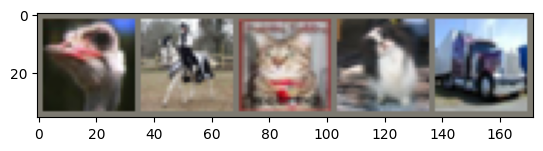

GroundTruth:  bird  horse cat   dog   truck


In [18]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images[:n_imgs], labels[:n_imgs]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(n_imgs)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [19]:
vit = timm.create_model('vit_base_patch8_224_in21k', pretrained=True, img_size=32, num_classes=10, drop_rate=0.1)
vit.load_state_dict(torch.load('./weights/cifar_vit_base_patch8_224_in21k.pth'))
vit.eval()
vit = vit.to(device)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [20]:
outputs = vit(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(n_imgs)))

Predicted:  bird  horse cat   dog   truck


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [21]:
acc(vit, test_loader)

92.49000000000001

In [22]:
convnext.load_state_dict(torch.load('./weights/cifar_convnext_base_in22k.pth'))
vit.to(device)
acc(convnext, test_loader)

91.61

Hmmm, what are the classes that performed well, and the classes that did
not perform well:

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


def class_stats(model, data_loader, classes):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    all_preds = []
    all_labels = []
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # again no gradients needed
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect all preds/labels for confusion matrix later
            all_preds.extend(predictions.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    print()
        
    cm = confusion_matrix([classes[i] for i in all_labels], [classes[i] for i in all_preds], labels=classes)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    print({i: classes[i] for i in range(len(classes))})

Accuracy for class: plane is 95.0 %
Accuracy for class: car   is 95.2 %
Accuracy for class: bird  is 91.0 %
Accuracy for class: cat   is 82.4 %
Accuracy for class: deer  is 93.2 %
Accuracy for class: dog   is 85.9 %
Accuracy for class: frog  is 95.8 %
Accuracy for class: horse is 94.4 %
Accuracy for class: ship  is 96.4 %
Accuracy for class: truck is 95.6 %

{0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


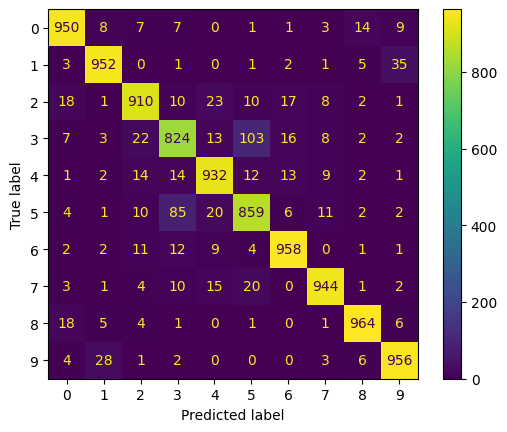

In [24]:
class_stats(vit, test_loader, classes)

### 6. Other Topics


#### 6.1 Ensembling models

- often boosts performance quite a bit
- makes the approaches more stable
- however, it requires running multiple models

In [25]:
class Ensemble(nn.Module):

    def __init__(self, nets):
        super().__init__()
        self.nets = nn.ModuleList([net for net in nets])
    
    def forward(self, x):
        out = None
        for net in self.nets:
            out = net(x) if out == None else out + net(x)
        return out / len(self.nets)


ensemble = Ensemble([vit, convnext])
ensemble = ensemble.to(device)

In [26]:
acc(ensemble, test_loader)

94.06

Accuracy for class: plane is 96.6 %
Accuracy for class: car   is 96.2 %
Accuracy for class: bird  is 93.3 %
Accuracy for class: cat   is 86.3 %
Accuracy for class: deer  is 94.6 %
Accuracy for class: dog   is 88.5 %
Accuracy for class: frog  is 97.1 %
Accuracy for class: horse is 94.7 %
Accuracy for class: ship  is 96.6 %
Accuracy for class: truck is 96.7 %

{0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


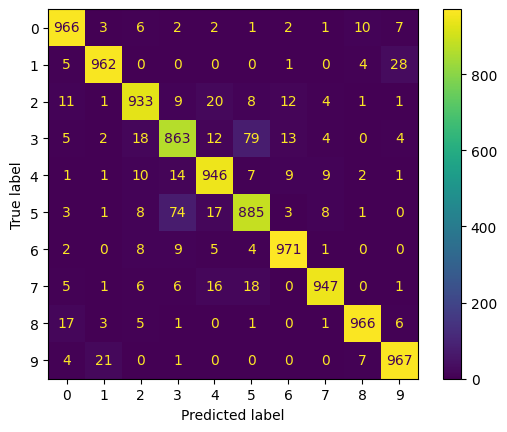

In [27]:
class_stats(ensemble, test_loader, classes)

#### 6.2 Exporting and optimizing models

In [28]:
export_model = timm.create_model(
    model_name,
    num_classes=10,
    in_chans=3,
    img_size=32,
    pretrained=True,
    checkpoint_path='./weights/cifar_vit_base_patch8_224_in21k.pth',
    exportable=True
)

export_model.eval()
example_input = torch.randn((1, 3, 32, 32), requires_grad=True)

input_names = ['actual_input']
output_names = ['output']

dynamic_axes_dict = {
    'actual_input': {
        0: 'bs',
    },
    'output': {
        0: 'bs'
    }
} 

export_model(example_input)

torch_out = torch.onnx.export(
    export_model.to(device), 
    example_input.to(device), 
    'cifar_vit.onnx',
    verbose=False,
    input_names=input_names,
    output_names=output_names,
    dynamic_axes=dynamic_axes_dict,
    export_params=True
)

/home/user/dev/r2r_workshop_cls/.venv/lib/python3.10/site-packages/torch/__init__.py:853: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


In [29]:
import onnx

onnx_model = onnx.load("cifar_vit.onnx")
onnx.checker.check_model(onnx_model)

In [30]:
import onnxruntime as ort

ort_session = ort.InferenceSession('cifar_vit.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
example_input = torch.randn((1, 3, 32, 32), requires_grad=True)
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(example_input.to(device))}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(export_model(example_input.to(device))), ort_outs[0], rtol=1e-02, atol=1e-05)

print('Exported model has been tested with ONNXRuntime, and the result looks good!')

Exported model has been tested with ONNXRuntime, and the result looks good!


In [31]:
import time

def test_speed(func):
    start = time.time()
    input_time = 0
    for i in range(1000):
        start_input = time.time()
        x = torch.randn((1, 3, 32, 32), requires_grad=True).to(device)
        input_time += (time.time() - start_input)
        func(x)
    return time.time() - start - input_time

In [32]:
onnx_time = test_speed(lambda x: ort_session.run(None, {ort_session.get_inputs()[0].name: to_numpy(x)}))
onnx_time

1.7856605052947998

In [33]:
export_model.to(device)
pytorch_time = test_speed(export_model)
pytorch_time

4.998410701751709

In [34]:
pytorch_time / onnx_time

2.799194296413308